In [75]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile

# **Kaggle dataset**

In [77]:
!kaggle datasets download -d sbhatti/news-summarization

Dataset URL: https://www.kaggle.com/datasets/sbhatti/news-summarization
License(s): CC0-1.0
news-summarization.zip: Skipping, found more recently modified local copy (use --force to force download)


In [78]:
with zipfile.ZipFile('news-summarization.zip', 'r') as zip_ref:
    zip_ref.extractall('news-summarization')

In [79]:
news_data = pd.read_csv("news-summarization/data.csv")

In [80]:
news_data.head()

,Unnamed: 0,ID,Content,Summary,Dataset
0,0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail
1,1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail
2,2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail
3,3,e12b5bd7056287049d9ec98e41dbb287bd19a981,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail
4,4,b83e8bcfcd51419849160e789b6658b21a9aedcd,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail


In [15]:
print(news_data["Content"][0])
print()
print(news_data["Summary"][0])

New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks. Until now police haven't acknowledged drones as a potential weapon, but the NYPD has now said the technology has advanced enough that someone could use them to carry out an air assault using chemical weapons and firearms. Police want to develop technology which will allow them to take control of drones as well as scan the skies for them before major events. The NYPD says drones carrying explosives are the number one threat as they investigate ways to stop attacks . Deputy Chief Salvatore DiPace, left, was concerned about an incident last year where a drone was landed in front of German Chancellor Angela Merkel and 'could have took the chancellor and her people out' A drone which was flown over a packed football stadium in Manchester, England, just over a week ago, resulting in the suspected pilot being arrested . They are consulting with the military and members

In [51]:
lengths_article = news_data["Content"].str.len()
lengths_article.describe()

count    8.704870e+05
mean     4.008553e+03
std      5.585502e+03
min      1.400000e+01
25%      2.052000e+03
50%      3.316000e+03
75%      4.958000e+03
max      2.921656e+06
Name: Content, dtype: float64

In [58]:
news_data = news_data[(lengths_article >= lengths_article.quantile(0.05)) & (lengths_article <= lengths_article.quantile(0.95))]

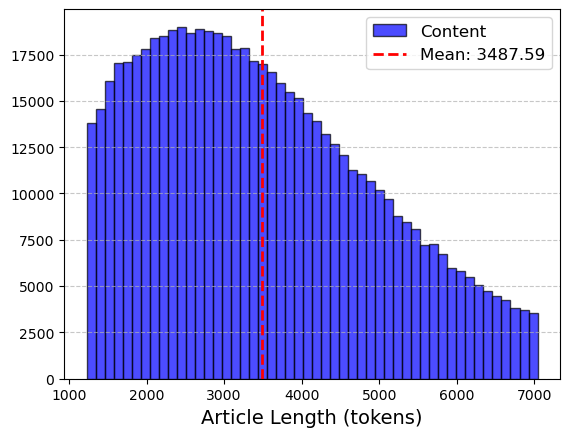

In [74]:
pd.DataFrame(news_data["Content"].str.len()).plot(kind='hist', bins=50, edgecolor='black', alpha=0.7, color='blue')
plt.axvline(news_data["Content"].str.len().mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {news_data["Content"].str.len().mean():.2f}')
plt.xlabel("Article Length (tokens)", fontsize=14)
plt.ylabel("")
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [61]:
lengths_summary = news_data["Summary"].str.len()
lengths_summary.describe()

count    696451.000000
mean        283.484382
std         208.280906
min           1.000000
25%         163.000000
50%         247.000000
75%         326.000000
max        8541.000000
Name: Summary, dtype: float64

In [62]:
news_data = news_data[(lengths_summary >= lengths_summary.quantile(0.05)) & (lengths_summary <= lengths_summary.quantile(0.95))]

In [63]:
news_data["Summary"].str.len().describe()

count    627296.000000
mean        255.481042
std          98.145850
min         105.000000
25%         178.000000
50%         247.000000
75%         316.000000
max         556.000000
Name: Summary, dtype: float64

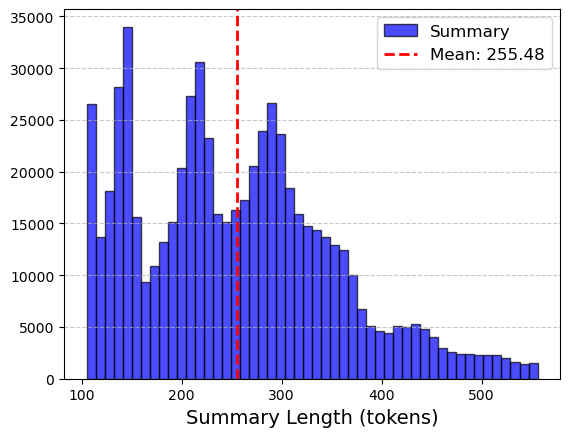

In [73]:
news_data["Summary"].str.len().plot(kind='hist', bins=50, edgecolor='black', alpha=0.7, color='blue')
plt.axvline(news_data["Summary"].str.len().mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {news_data["Summary"].str.len().mean():.2f}')
plt.xlabel("Summary Length (tokens)", fontsize=14)
plt.ylabel("")
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **LLM Llama 3.2**

In [ ]:
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
import yaml

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

hf_token = config["huggingface"]["token"]
login("hf_token")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")